We acquired our training set for sentiment analysis from Media Tenor International, a Swiss-based media analysis institute. Specifically, we received an Excel file containing details such as the article's publication date, source, title, sentiment topic (e.g., sentiment towards business cycle conditions), the number of annotators who evaluated each article as negative, neutral, or positive, and the total number of annotators per article. 

In this notebook, we analyze the Media Tenor dataset to produce its summary and descriptive statistics. 

---

The original Media Tenor dataset includes 16,874 annotated articles. However, 295 of these articles had empty titles, making it impossible to locate them in LexisNexis and Factiva. Consequently, we removed these entries, resulting in a dataset of 16,579 annotated articles.

In [1]:
import pandas as pd

# Open the file acquired from Media Tenor
sentiment_data = pd.read_csv('Daten_Wirtschaftliche_Lage.csv', encoding = 'utf-8', sep=';')

# Calculate the number of annotated articles with empty titles
num_empty_titles = sentiment_data['title'].isnull().sum()

# Print the number of articles with empty titles
print(f"Number of articles with empty titles: {num_empty_titles}")

# Remove articles with empty titles since they cannot be matched
sentiment_data = sentiment_data[sentiment_data['title'].notnull()]

# Reset the index of the DataFrame
sentiment_data.reset_index(drop=True, inplace=True)

# Print the number of annotations in the Media Tenor dataset
num_annotations = len(sentiment_data)
print(f"Number of annotations in the Media Tenor dataset: {num_annotations}")

Number of articles with empty titles: 295
Number of annotations in the Media Tenor dataset: 16579


In [2]:
sentiment_data.head()

,date,month,medium,title,topicgroup,negative,no_clear_tone,positive,Number_of_reports,AverageRating
0,01.01.2014,201401,WamS,Koalition,Konjunktur,0,1,0,1,0
1,01.01.2017,201701,FAS,Habt bloß keine Angst vor China !,Internationale Wirtschaft,0,0,1,1,100
2,01.01.2017,201701,BamS,Wir leben in einer Zeit der Wohlstands-Halluzi...,Konjunktur,0,0,1,1,100
3,01.02.2015,201502,WamS,Teheran ruft,Wettbewerbsfähigkeit/Nachfrage,1,3,0,4,-25
4,01.01.2017,201701,BamS,"Geht es und wirklich so gut, wie es uns Merkel...",Internationale Wirtschaft,0,1,0,1,0


We define the sentiment of an article based on the number of annotators who assessed it as negative, having no clear tone, or positive. The sentiment is determined using a majority vote approach. If no agreement between annotators is reached, we remove the annotation from the dataset.

In [3]:
def year(row):
    '''
    Extract the year from the 'date' column.
    '''
    # Split the date string by '.' and take the third part, then convert it to an integer
    return int(row['date'].split('.')[2])

def month(row):
    '''
    Extract the month from the 'date' column.
    '''
    # Split the date string by '.' and take the second part, then convert it to an integer
    return int(row['date'].split('.')[1])

# Apply the 'year' function to each row of the DataFrame and create a new 'year' column
# The 'axis=1' parameter indicates that the function is applied to each row
sentiment_data['year'] = sentiment_data.apply(lambda row: year(row), axis=1)

# Apply the 'month' function to each row of the DataFrame and create a new 'month' column
# The 'axis=1' parameter indicates that the function is applied to each row
sentiment_data['month'] = sentiment_data.apply(lambda row: month(row), axis=1)

In [4]:
def sentiment(row):
    '''
    Determine the sentiment of an article based on the majority vote of annotators.
    '''
    # Check if 'negative' has the majority vote
    if (row['negative'] > row['no_clear_tone']) & (row['negative'] > row['positive']):
        return -1
    # Check if 'positive' has the majority vote
    if (row['positive'] > row['negative']) & (row['positive'] > row['no_clear_tone']):
        return 1
    # Check if 'no_clear_tone' has the majority vote
    if (row['no_clear_tone'] > row['negative']) & (row['no_clear_tone'] > row['positive']):
        return 0
    # If no agreement between annotators, return NaN
    return float('NaN')

# Apply the 'sentiment' function to each row of the DataFrame and create a new 'sentiment' column
sentiment_data['sentiment'] = sentiment_data.apply(lambda row: sentiment(row), axis=1)

# Remove articles where there is no annotator agreement (i.e., sentiment is NaN)
sentiment_data = sentiment_data[sentiment_data['sentiment'].notnull()]

# Print the number of annotations in the Media Tenor dataset
num_annotations = len(sentiment_data)
print(f"Number of annotations in the Media Tenor dataset: {num_annotations}")

Number of annotations in the Media Tenor dataset: 15831


In [5]:
def positive_sentiment(row):
    '''
    Indicate whether an article has a positive sentiment.
    '''
    if row['sentiment'] == 1:
        return 1
    else:
        return 0

def negative_sentiment(row):
    '''
    Indicate whether an article has a negative sentiment.
    '''
    if row['sentiment'] == -1:
        return 1
    else:
        return 0

# Apply the 'positive_sentiment' function to each row of the DataFrame and create a new 'pos' column
sentiment_data['pos'] = sentiment_data.apply(lambda row: positive_sentiment(row), axis=1)

# Apply the 'negative_sentiment' function to each row of the DataFrame and create a new 'neg' column
sentiment_data['neg'] = sentiment_data.apply(lambda row: negative_sentiment(row), axis=1)

The dataset includes annotations for 58 topics. The top five topics by number of annotations are: Business Cycle Conditions with 4,109 annotations, Fiscal Policy with 2,641 annotations, Labour Market with 2,390 annotations, International Economy with 1,118 annotations, and Monetary Policy with 1,110 annotations.

In [6]:
import collections

# Count the number of annotations for each topic in the 'topicgroup' column
counter = collections.Counter(sentiment_data['topicgroup'])

# Print the count of annotations for each topic
print(counter)

num_unique_topics = len(counter)
print(f"Number of unique topics in the dataset: {num_unique_topics}")

Counter({'Konjunktur': 4109, 'Haushaltspolitik': 2641, 'Arbeitsmarkt': 2390, 'Internationale Wirtschaft': 1118, 'Währungspolitik/EURO/Geldpolitik': 1110, 'Wirtschaftspolitik': 872, 'Steuerpolitik': 834, 'Wirtschaftsstandort': 801, 'Wettbewerbsfähigkeit/Nachfrage': 734, 'Märkte': 199, 'EU': 111, 'Krankheiten': 81, 'Technik, Wissenschaft': 76, 'Arbeitskosten': 71, 'Sozialpolitik': 70, 'Werte': 54, 'Minderheiten': 45, 'Innere Sicherheit/Kriminalität': 41, 'Personalpolitik': 39, 'Verkehrspolitik': 38, 'Umweltpolitik, Klima, Umweltschutz': 37, 'Rentenpolitik': 32, 'Deutsche Einheit': 25, 'Bildung': 25, 'Verbraucherschutz': 23, 'Gesundheitspolitik': 22, 'Innenpolitik': 18, 'Entwicklungshilfe': 17, 'Regulierung/politische Stellungnahmen': 15, 'Fossile Energie': 15, 'Geschichte allgemein': 15, 'Militär': 13, 'Tourismus': 13, 'Parteipolitik': 12, 'Internationale Konflikte': 12, 'Strategie (Unternehmen)': 10, 'Wohnungsbau': 9, 'Energiepolitik': 9, 'Frauen/Familie/Homosexuelle': 8, 'Unfälle, Kata

The annotated articles in the dataset come from several sources. The distribution of annotations by source is as follows: Spiegel with 4,205 annotations, BILD with 4,122 annotations, Focus with 2,818 annotations, WamS with 1,485 annotations, Capital with 1,411 annotations, FAS with 1,048 annotations, BamS with 718 annotations, and Manager Magazin only with 24 annotations.

In [7]:
# Count the number of annotations for each source in the 'medium' column
counter = collections.Counter(sentiment_data['medium'])

# Print the count of annotations for each source
print(counter)

Counter({'Spiegel': 4205, 'BILD': 4122, 'Focus': 2818, 'WamS': 1485, 'Capital': 1411, 'FAS': 1048, 'BamS': 718, 'Manager Magazin': 24})


The same article can be annotated multiple times towards different topics. Therefore, the number of unique articles in the dataset is less than the total number of annotations, which is 15,831. Specifically, there are 12,857 unique articles in the dataset. This means that 1,916 articles were annotated at least twice towards different topics.

In [8]:
# Drop duplicate articles based on the 'title' column
# This is to calculate how many unique articles are annotated in the corpus
# The 'keep' parameter is set to 'first' to keep the first occurrence of each duplicate
unique_articles = sentiment_data.drop_duplicates(['title'], keep='first')

# Calculate the number of unique articles
num_unique_articles = len(unique_articles)

# Print the number of unique articles
print(f"Number of unique articles annotated in the dataset: {num_unique_articles}")

Number of unique articles annotated in the dataset: 12857


In [9]:
# Identify duplicated titles
duplicated_titles = sentiment_data['title'].duplicated(keep=False)

# Filter the DataFrame to get only rows with duplicated titles
duplicated_articles = sentiment_data[duplicated_titles]

# Get the unique duplicated titles
unique_duplicated_titles = duplicated_articles['title'].unique()

# Calculate the number of unique duplicated titles
num_duplicated_titles = len(unique_duplicated_titles)

# Print the number of titles that are met more than once
print(f"Number of titles annotated at least twice: {num_duplicated_titles}")

Number of titles annotated at least twice: 1916


For example, the article titled "Habt bloß keine Angst vor China!" has a positive sentiment towards both International Economy and Economic Policy.

In [10]:
# Select one example of a duplicated title
example_title = unique_duplicated_titles[0]

# Filter the DataFrame to show only rows with the example duplicated title
example_duplicated_articles = sentiment_data[sentiment_data['title'] == example_title]

# Display annotations for the same article
example_duplicated_articles

,date,month,medium,title,topicgroup,negative,no_clear_tone,positive,Number_of_reports,AverageRating,year,sentiment,pos,neg
1,01.01.2017,1,FAS,Habt bloß keine Angst vor China !,Internationale Wirtschaft,0,0,1,1,100,2017,1.0,1,0
6,01.01.2017,1,FAS,Habt bloß keine Angst vor China !,Wirtschaftspolitik,0,0,1,1,100,2017,1.0,1,0


In our project, we focus on sentiment towards business cycle conditions, the topic with the highest number of annotations and significant importance for economic forecasting. Next, we construct monthly sentiment indices based on Media Tenor's annotations for business cycle conditions and labour market topics. We aim to show that aspect-based sentiment analysis is important because, although these sentiment indices are correlated, they are not identical. There are periods where their behaviors diverge significantly. The labour market topic is chosen for its substantial representation in the dataset and its relevance to macroeconomic forecasting.

A significant advantage of using the Media Tenor dataset is that the articles were annotated by professional coders. In cases where the sentiment was unclear, multiple annotators reviewed the article. For instance, with articles related to business cycle conditions, most were annotated by a single person (3,371 annotations). However, in 295 cases, two people were involved; in 202 cases, three people annotated the article; and there was even one instance where 26 people provided their annotations. This level of thorough annotation requires considerable resources.

In [11]:
# Filter the DataFrame for articles in the 'Konjunktur' topic group, excluding the year 2002
konjunktur = sentiment_data[(sentiment_data['topicgroup'] == 'Konjunktur') & (sentiment_data['year'] != 2002)]

# Sort the data in chronological order by year and month
konjunktur = konjunktur.sort_values(['year', 'month'], ascending=[True, True])

# Reset the index of the DataFrame
konjunktur.reset_index(drop=True, inplace=True)

# Calculate how many articles are annotated by 1, 2, 3, etc., annotators using the 'Number_of_reports' column
counter = collections.Counter(konjunktur['Number_of_reports'])

# Print the count of articles by number of annotators
print(counter)

Counter({1: 3371, 2: 295, 3: 202, 4: 101, 5: 52, 6: 33, 7: 13, 8: 11, 10: 7, 9: 5, 11: 4, 16: 4, 15: 3, 12: 3, 13: 2, 18: 1, 26: 1})


In [12]:
# Display the resulting DataFrame
konjunktur.head()

,date,month,medium,title,topicgroup,negative,no_clear_tone,positive,Number_of_reports,AverageRating,year,sentiment,pos,neg
0,03.01.2011,1,Focus,7 Aktien- & Fonds-Trends,Konjunktur,0,0,9,9,100,2011,1.0,1,0
1,17.01.2011,1,Focus,Frisches Geld für Aktionäre,Konjunktur,0,0,1,1,100,2011,1.0,1,0
2,21.01.2011,1,Manager Magazin,keine 5 Zeilen,Konjunktur,0,1,0,1,0,2011,0.0,0,0
3,07.02.2011,2,Focus,Das Inflationsgefühl täuscht nicht,Konjunktur,0,2,0,2,0,2011,0.0,0,0
4,14.02.2011,2,Spiegel,keine 5 Zeilen,Konjunktur,0,0,1,1,100,2011,1.0,1,0


The sentiment annotations towards business cycle conditions come from various sources: 1,020 annotations from Spiegel, 875 from BILD, 730 from Focus, 488 from WamS, 411 from Capital, 392 from FAS, 176 from BamS, and 16 from Manager Magazin.

In [13]:
# Count the number of annotations for each source in the 'medium' column
counter = collections.Counter(konjunktur['medium'])

# Print the count of annotations for each source
print(counter)

Counter({'Spiegel': 1020, 'BILD': 875, 'Focus': 730, 'WamS': 488, 'Capital': 411, 'FAS': 392, 'BamS': 176, 'Manager Magazin': 16})


The average number of sentiment annotations towards business cycle conditions is 36.35 per month.

In [14]:
# Group by year and month to count the number of annotations per month
monthly_annotations = konjunktur.groupby(['year', 'month']).size()

# Calculate the average number of annotations per month
average_annotations_per_month = monthly_annotations.mean()

# Print the result
print(f"Average number of annotations towards business cycle conditions per month: {average_annotations_per_month:.2f}")

Average number of annotations towards business cycle conditions per month: 36.35


In [15]:
# Filter the DataFrame for articles in the 'Arbeitsmarkt' ('Labour Market') topic group
lm = sentiment_data[sentiment_data['topicgroup'] == 'Arbeitsmarkt']

# Sort the data in chronological order by year and month
lm = lm.sort_values(['year', 'month'], ascending=[True, True])

# Reset the index of the DataFrame
lm.reset_index(drop=True, inplace=True)

# Calculate how many articles are annotated by 1, 2, 3, etc., annotators using the 'Number_of_reports' column
counter = collections.Counter(lm['Number_of_reports'])

# Print the count of articles by number of annotators
print(counter)

Counter({1: 2210, 2: 70, 3: 46, 4: 22, 5: 12, 7: 4, 6: 4, 11: 2, 16: 2, 8: 2, 29: 2, 9: 2, 17: 1, 24: 1, 19: 1, 21: 1, 10: 1, 33: 1, 14: 1, 23: 1, 13: 1, 27: 1, 18: 1, 12: 1})


In [16]:
# Display the resulting DataFrame
lm.head()

,date,month,medium,title,topicgroup,negative,no_clear_tone,positive,Number_of_reports,AverageRating,year,sentiment,pos,neg
0,16.04.2011,4,Focus,"schupelius, gunnar",Arbeitsmarkt,0,1,0,1,0,2011,0.0,0,0
1,16.05.2011,5,Focus,keine 5 Zeilen,Arbeitsmarkt,0,1,0,1,0,2011,0.0,0,0
2,01.07.2011,7,BILD,Job-Boom geht weiter!,Arbeitsmarkt,0,0,1,1,100,2011,1.0,1,0
3,04.07.2011,7,Focus,Montag ist Zeugnistag,Arbeitsmarkt,1,0,0,1,-100,2011,-1.0,0,1
4,04.07.2011,7,Focus,Lichtblicke für Saab Werker,Arbeitsmarkt,0,0,1,1,100,2011,1.0,1,0


The sentiment annotations towards labour market come from various sources: 887 annotations from BILD, 599 from Spiegel, 356 from Focus, 209 from WamS, 135 from Capital, 108 from FAS, and 96 from BamS.

In [17]:
# Count the number of annotations for each source in the 'medium' column
counter = collections.Counter(lm['medium'])

# Print the count of annotations for each source
print(counter)

Counter({'BILD': 887, 'Spiegel': 599, 'Focus': 356, 'WamS': 209, 'Capital': 135, 'FAS': 108, 'BamS': 96})


The average number of sentiment annotations towards labour market is 21.93 per month.

In [18]:
# Group by year and month to count the number of annotations per month
monthly_annotations_lm = lm.groupby(['year', 'month']).size()

# Calculate the average number of annotations per month
average_annotations_per_month_lm = monthly_annotations_lm.mean()

# Print the result
print(f"Average number of annotations towards labour market per month: {average_annotations_per_month_lm:.2f}")

Average number of annotations towards labour market per month: 21.93


In [19]:
def sentiment_index(period, data, topic_name):
    
    """
    Calculate the sentiment index for a specific topic over different time periods.

    Parameters:
    period (str): The period over which to group the data (e.g., 'month').
    data (DataFrame): The DataFrame containing sentiment annotations for a specific topic, 
    including 'year', 'pos', 'neg', and the specified period column.
    topic_name (str): The name of the topic for which the sentiment index is being calculated. 
    This will be used in the output file name.

    Returns:
    DataFrame: A DataFrame containing the 'year' and 'sentiment_index' for each period.
    """
        
    years = list(range(2011, 2021))
    numerator_list = []
    denominator_list = []
    year_list = []
    period_list = []

    # Loop through each year and calculate the numerator and denominator
    for year in years:
        data_group = data[data.year == year].groupby(period)
        numerator = data_group['pos'].sum() - data_group['neg'].sum()
        denominator = data_group.size()
        
        numerator_list.append(numerator)
        denominator_list.append(denominator)
        year_list.extend([year] * len(numerator))
        period_list.extend(data_group.groups.keys())

    # Combine results into a DataFrame
    sentiment_index_df = pd.DataFrame({
        'year': year_list,
        period: period_list,
        'sentiment_index_numerator': pd.concat(numerator_list),
        'sentiment_index_denominator': pd.concat(denominator_list)
    })
    
    # Calculate the sentiment index
    sentiment_index_df['sentiment_index'] = sentiment_index_df['sentiment_index_numerator'] / sentiment_index_df['sentiment_index_denominator']
    
    # Save sentiment index to Excel file
    file_name = f'{topic_name}_{period}.xlsx'
    sentiment_index_df.to_excel(file_name, index=False)
    
    return sentiment_index_df[['year', 'sentiment_index']]

In [20]:
import pandas as pd

# Open the file acquired from Media Tenor
sentiment_data = pd.read_csv('Daten_Wirtschaftliche_Lage.csv', encoding = 'utf-8', sep=';')

# Remove articles with empty titles since they cannot be matched
sentiment_data = sentiment_data[sentiment_data['title'].notnull()]

In [21]:
len(counter.keys())

7

In the picture, we can observe distinct periods where the sentiment towards business cycle conditions and the labour market diverge. For instance, in 2016, there is a significant drop in sentiment towards business cycle conditions, whereas the sentiment towards the labour market remains stable.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


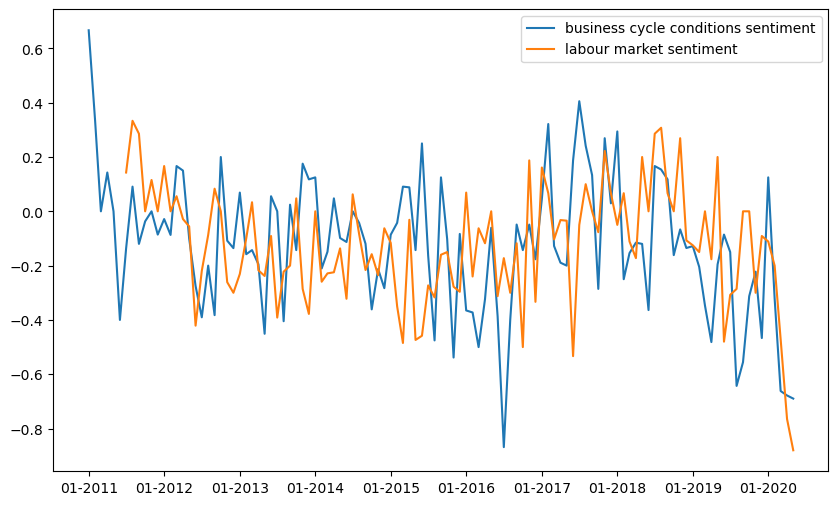

In [22]:
# Calculate sentiment indices towards business cycle conditions and labour market
konjunktur_sentiment = sentiment_index('month', konjunktur, 'konjunktur').reset_index()
labour_market_sentiment = sentiment_index('month', lm, 'lm').reset_index()

# Merge the 'konjunktur_sentiment' and 'labour_market_sentiment' DataFrames on the 'month' and 'year' columns using a left join
merged_sentiment = pd.merge(konjunktur_sentiment, labour_market_sentiment, how='left', on=['month', 'year'])

def ym(row):
    '''
    Convert year and month to a datetime object representing the first day of the month.
    '''
    if row['month'] <= 9:
        return pd.to_datetime(str(int(row['year'])) + '-' + '0' + str(int(row['month'])) + '-' + '01')
    else:
        return pd.to_datetime(str(int(row['year'])) + '-' + str(int(row['month'])) + '-' + '01')

# Apply the 'ym' function to create a new 'date' column
# The 'date' column represents the first day of the month for the specified 'year' and 'month' in each row
merged_sentiment['date'] = merged_sentiment.apply(lambda row: ym(row), axis=1)

# Rename columns for better readability
merged_sentiment = merged_sentiment.rename(columns={'sentiment_index_x': 'business cycle conditions', 'sentiment_index_y': 'labour market'})

# Create a new DataFrame with selected columns and set 'date' as the index
final_sentiment = merged_sentiment[['date', 'business cycle conditions', 'labour market']].set_index('date')

# Find the index of the last NaN value in the 'labour market' column
last_nan_index = final_sentiment['labour market'].isna().cumsum().idxmax()

# Filter the DataFrame to start from the first non-NaN value after the last NaN
final_sentiment_filtered = final_sentiment.loc[last_nan_index:].dropna(subset=['labour market'])

# Plot the sentiment indices
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
# Set the major formatter for the x-axis to display dates in 'MM-YYYY' format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
# Plot the business cycle conditions sentiment against the date
ax.plot(final_sentiment.index, final_sentiment['business cycle conditions'], label='business cycle conditions sentiment')
# Plot the labour market sentiment against the date
ax.plot(final_sentiment_filtered.index, final_sentiment_filtered['labour market'], label='labour market sentiment')
ax.legend()
# Save the plot
plt.savefig('konjunktur_lm.eps', format='eps')
plt.savefig('konjunktur_lm.png', format='png')
plt.show()

In [23]:
correlation = final_sentiment_filtered['business cycle conditions'].corr(final_sentiment_filtered['labour market'])
print(f"Correlation between sentiment towards business cycle conditions and labour market: {correlation:.2f}")

Correlation between sentiment towards business cycle conditions and labour market: 0.34


Additionally, we want to show that 165 articles were annotated towards both business cycle conditions and the labour market. Among them, about half of the articles had non-matching sentiment towards these two topics, emphasizing the importance of aspect-based sentiment analysis.

In [24]:
# Merge the DataFrames on 'title' and 'date' using an inner join
data_match = pd.merge(konjunktur, lm, how='inner', on=['title', 'date'], suffixes=('_business_cycle', '_labour_market'))

# Select and rename the relevant columns
data_match = data_match[['date', 'medium_business_cycle', 'title', 'sentiment_business_cycle', 'sentiment_labour_market']]
data_match = data_match.rename(columns={'medium_business_cycle': 'medium'})

# Display the first few rows of the merged DataFrame
data_match.head()

,date,medium,title,sentiment_business_cycle,sentiment_labour_market
0,18.08.2011,Capital,Die Zäsur,0.0,0.0
1,22.08.2011,Focus,Börse fürchtet Rückkehr,0.0,-1.0
2,05.12.2011,Focus,Globale Gefahren,1.0,1.0
3,18.02.2012,Focus,"Mehr Jobs, mehr Kauflust",1.0,1.0
4,27.02.2012,Focus,Was die Krise kostet,-1.0,-1.0


In [25]:
# Calculate the number of articles with matching and non-matching sentiments
total_articles = len(data_match)
non_matching_sentiments = len(data_match[data_match['sentiment_business_cycle'] != data_match['sentiment_labour_market']])

# Filter for articles with specific sentiment differences
negative_business_cycle_positive_labour_market = data_match[
    (data_match['sentiment_business_cycle'] == -1) & (data_match['sentiment_labour_market'] == 1)
]

# Display the results
print(f"Total articles annotated towards both business cycle conditions and labour market: {total_articles}")
print(f"Articles with non-matching sentiments: {non_matching_sentiments}")
print(f"Articles with negative sentiment towards business cycle conditions and positive sentiment towards labour market: {len(negative_business_cycle_positive_labour_market)}")

Total articles annotated towards both business cycle conditions and labour market: 165
Articles with non-matching sentiments: 80
Articles with negative sentiment towards business cycle conditions and positive sentiment towards labour market: 14


In [26]:
# Create a DataFrame to display the examples
example_articles = data_match[
    data_match['sentiment_business_cycle'] != data_match['sentiment_labour_market']
][['date', 'title', 'medium', 'sentiment_business_cycle', 'sentiment_labour_market']]

# Display the example articles DataFrame
print("Example articles with non-matching sentiments:")
example_articles.head()

Example articles with non-matching sentiments:


,date,title,medium,sentiment_business_cycle,sentiment_labour_market
1,22.08.2011,Börse fürchtet Rückkehr,Focus,0.0,-1.0
7,18.07.2012,Droht eine neue Kündigungswelle?,BILD,-1.0,0.0
8,19.07.2012,Wir dürfen keine Märchen erzählen,Capital,-1.0,0.0
9,05.08.2012,Wo bleiben sie denn?,FAS,0.0,-1.0
10,16.08.2012,Zeit stolz zu sein,BILD,-1.0,1.0


In [27]:
# Create a DataFrame to display the specific examples where sentiment towards business cycle is negative and towards labour market is positive
specific_example_articles = negative_business_cycle_positive_labour_market[['date', 'title', 'medium', 'sentiment_business_cycle', 'sentiment_labour_market']]

# Display the specific example articles DataFrame
print("Example articles with negative sentiment towards business cycle and positive sentiment towards labour market:")
specific_example_articles.head()

Example articles with negative sentiment towards business cycle and positive sentiment towards labour market:


,date,title,medium,sentiment_business_cycle,sentiment_labour_market
10,16.08.2012,Zeit stolz zu sein,BILD,-1.0,1.0
20,05.12.2012,Wir sind die erfolgreichste Regierung seit der...,BILD,-1.0,1.0
30,19.05.2013,Herr Flassbeck irrt,FAS,-1.0,1.0
41,27.01.2014,Deutschland ist der Goldstandard,Spiegel,-1.0,1.0
57,02.06.2014,Besser als Einheimische,Spiegel,-1.0,1.0
